In [2040]:
%load_ext autoreload
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2041]:
%autoreload 2
import FEMOL
import numpy as np
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata, interp2d, RectBivariateSpline
import time
import runpy
import os
import sys
import pygmsh

# Development Notebook for the FEMOL Project

In [645]:
def highest_key(msh):
    for i in range(1, 100):
        if f'm{i}_Uz' in msh.point_data.keys():
            pass
        else:
            return f'm{i-1}_Uz'
        
def TOM_improvement(mesh_file, eigval_file, eigvec_file):
    
    fig, axs = plt.subplots(2, 5, figsize=(18, 6))
    # Load the mesh
    msh = FEMOL.mesh.load_vtk(mesh_file)
    # get the truncated filename
    msh_f_name = msh_f.split('/')[-1]
    mode = msh_f_name[11:14]
    layup = '[' + '/'.join((msh_f_name[15:-4].split('_'))) + ']'
    # Load the eigenvalues
    eigs = np.load(eigval_file)
    # Load the eigenvectors
    vecs = np.load(eigvec_file)
    # Plot the guitar outline
    plt.sca(axs[0][0])
    FEMOL.utils.guitar_outline2(L=1)
    axs[0][0].set_title(f'mode {mode}')
    axs[0][0].set_axis_off()
    # Plot the topology result
    plt.sca(axs[1][0])
    mesh.cell_to_point_data('zc')
    mesh.plot.point_data('zc', cmap='Greys', wrapped=False)
    FEMOL.utils.guitar_outline2(L=1)
    axs[1][0].set_title(f'layup {layup}')

    for i in range(4):
        # Plot all the regular modes and frequencies
        ax = axs[0][int(i+1)]
        plt.sca(ax)
        mesh.plot.mode(vecs[0][i])
        ax.set_title(f'freq {int(np.round(eigs[0][i]))} Hz')
        # Plot all the optimized modes and frequencies
        ax = axs[1][i+1]
        plt.sca(ax)
        mesh.plot.mode(vecs[-1][i])
        ax.set_title(f'freq {int(np.round(eigs[-1][i]))} Hz')
    

In [646]:
root = 'Results/_topopt_cache/'
eigval_files = np.sort([root + f for f in os.listdir('Results/_topopt_cache/') if f[:6] == 'eigval'])
eigvec_files = np.sort([root + f for f in os.listdir('Results/_topopt_cache/') if f[:6] == 'eigvec'])
mesh_files = np.sort([root + f for f in os.listdir('Results/_topopt_cache/') if f[:3] == 'TOM'])


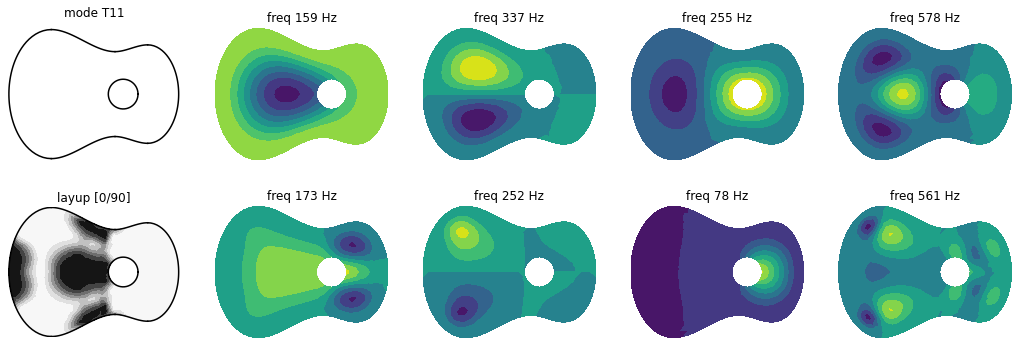

In [647]:
TOM_improvement(mesh_files[0], eigval_files[0], eigvec_files[0])

In [974]:
def guit_zc_solve(mesh_file, hc_opt, **kwargs):
    
    obj = FEMOL.problems.GuitarModal(**kwargs)
    zc_mesh = FEMOL.mesh.load_vtk(mesh_file)
    zc = zc_mesh.cell_data['zc']
    zc['quad'] *= hc_opt/0.010
    zc = add_top_brace_to_zc(zc_mesh, zc, 2*hc_opt)
    obj.problem.mesh.cell_data['zc'] = zc
    return obj

def ref_guit_zc_solve(mesh_file, hc_opt, **kwargs):
    obj = FEMOL.problems.GuitarModal(**kwargs)
    zc_mesh = FEMOL.mesh.load_vtk(mesh_file)
    zc = zc_mesh.cell_data['zc']
    zc = add_top_brace_to_zc(zc_mesh, zc, 2*hc_opt)
    zc['quad'] = np.ones_like(zc['quad'])*zc['quad'].mean()*(hc_opt/0.010)
    obj.problem.mesh.cell_data['zc'] = zc
    return obj

In [1019]:
modes = ['T11', 'T31']
files = {'T11':[0], 'T31':[-2]}
plies = [[0, 90], [45, -45]]
all_modes =  ['T11', 'T21', 'T12', 'T31']
vecs = [np.load(f'Results/guitar_modes/guitar_sym_mode_{mode}_lcar03.npy') for mode in all_modes]
all_eigvecsr = []
all_eigvecso = []
all_omegao = []

for mode, ply in zip(modes, plies):
    for file in files[mode]:
        print(f'$___{mode}__{ply}___$')
        obj = guit_zc_solve(mesh_files[file], hc_opt=0.010, h_flax=0.0025, plies_carbon=ply)
        w, v = obj.solve(solve_from_zc=True, h_min=0.001, mac_find=True, verbose=False)
        all_omegao.append(w)
        objr = ref_guit_zc_solve(mesh_files[file], hc_opt=0.010, h_flax=0.0025, plies_carbon=ply)
        wr, vr = objr.solve(solve_from_zc=True, h_min=0, mac_find=True, verbose=False)
        all_eigvecsr.append(vr)
        all_eigvecso.append(v)
        macs_opt = [FEMOL.utils.MAC(vi, vref) for vi, vref in zip(v, vecs)]
        macs_ref = [FEMOL.utils.MAC(vi, vref) for vi, vref in zip(vr, vecs)]       
        for f1, f2, mco, mcr, m in zip(wr, w, macs_opt, macs_ref, all_modes):
            try:
                incrs = tonal_increase(f1, f2)
            except:
                incrs = 0.
            print(f'{m} mac_ref:{np.around(mcr, 2)}, mac_opt:{np.around(mco, 2)}, tonal change: {incrs} ')


$___T11__[0, 90]___$
Tried modal assurance criterion with non symmetric mesh and failed...
Tried modal assurance criterion with non symmetric mesh and failed...
T11 mac_ref:0.97, mac_opt:0.59, tonal change: 6.098356317144033 
T21 mac_ref:0.91, mac_opt:0.18, tonal change: -3.2537677036392587 
T12 mac_ref:0.99, mac_opt:0.63, tonal change: 0.32278183040816444 
T31 mac_ref:0.91, mac_opt:0.16, tonal change: -7.780561562482351 
$___T31__[45, -45]___$
Tried modal assurance criterion with non symmetric mesh and failed...
Tried modal assurance criterion with non symmetric mesh and failed...
T11 mac_ref:0.96, mac_opt:0.75, tonal change: -0.4403194159260799 
T21 mac_ref:0.95, mac_opt:0.26, tonal change: -1.1742356322498715 
T12 mac_ref:0.98, mac_opt:0.72, tonal change: -3.8143606506557575 
T31 mac_ref:0.52, mac_opt:0.13, tonal change: 5.814467844728711 


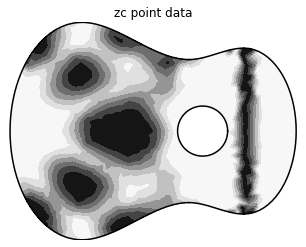

In [1029]:
mesh = FEMOL.mesh.load_vtk(mesh_files[-2])
mesh.cell_data['zc'] = add_top_brace_to_zc(mesh, mesh.cell_data['zc'], 0.010)
mesh.cell_to_point_data('zc')
mesh.plot.point_data('zc', cmap='Greys')
FEMOL.utils.guitar_outline2(L=1)

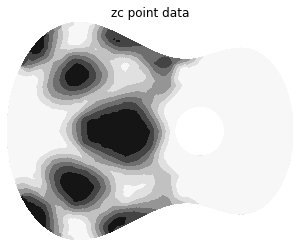

In [2029]:
mesh = FEMOL.mesh.load_vtk('soundboard_TOM_T31.vtk')
mesh.plot.point_data('zc', cmap='Greys')

In [2031]:
mesh = FEMOL.mesh.load_vtk('soundboard_TOM_T31.vtk')
zc = mesh.point_data['zc']
good_nodes = np.arange(mesh.points.shape[0])[zc>0.005]
good_cells = [cell for cell in mesh.plot.all_tris if all(ci in good_nodes for ci in cell)]
cell_groups = []

while True:

    try:
        node_groups = []
        current_group = [good_cells[0]]
        good_cells.pop(0)
        # For each cell in the current_group
        for cell_1 in current_group:
            # If a cell in good cells shares two nodes with the current group add it
            for i, cell_2 in enumerate(good_cells):
                intersect = len(set(cell_1).intersection(cell_2))
                if intersect == 2:
                    current_group.append(cell_2)
                    # Remove it from all the good cells
                    _ = good_cells.pop(i)
        if len(current_group)>2:
            cell_groups.append(current_group)
    except IndexError:
        break

        
        

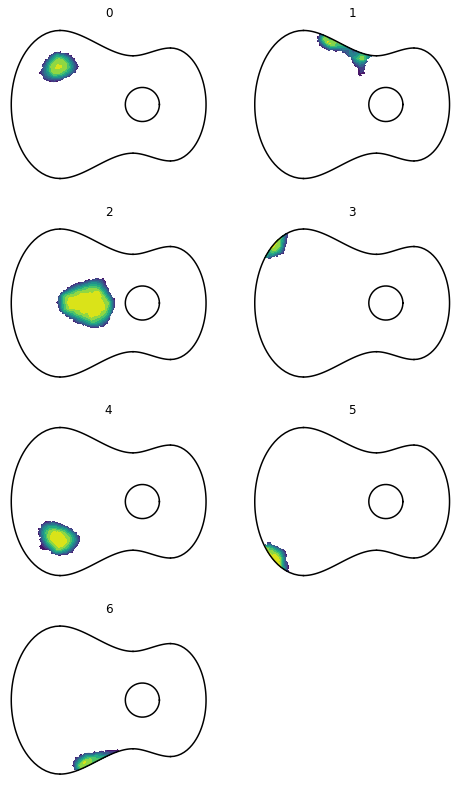

In [2057]:
#good_cells = np.array([cell for cell in mesh.cells['quad'] if all(ci in good_nodes for ci in cell)])
all_mesh = []
fig, axs = plt.subplots(len(cell_groups)//2 + len(cell_groups)%2, 2, figsize=(8, 14))
for i, group in enumerate(cell_groups):
    plt.sca(axs.flatten()[i])
    test_mesh = FEMOL.mesh.Mesh(mesh.points, {'triangle':np.array(group)})
    test_mesh.point_data['zc'] = zc[np.unique(group)]
    test_mesh.plot.point_data('zc')
    FEMOL.utils.guitar_outline2(L=0.48)
    axs.flatten()[i].set_title(i)
    all_mesh.append(test_mesh)
for i in range(len(axs.flatten()) - len(cell_groups)):
    axs.flatten()[-(i+1)].set_axis_off()

In [2066]:
center2.point_data_to_STL(filename='T31_center2', which='zc', symmetric=False, flip=True)

In [2074]:
center1.point_data_to_STL(filename='T31_center1', which='zc', symmetric=False)

In [2073]:
center1 = all_mesh[2]

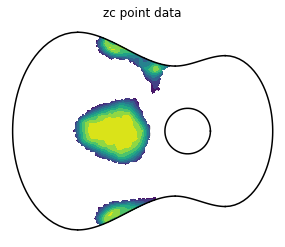

In [2070]:
for ci in np.array(all_mesh)[[1, 2, 6]]:
    ci.plot.point_data('zc')
FEMOL.utils.guitar_outline2(L=0.480)

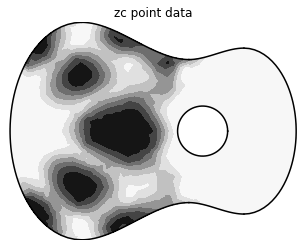

In [1363]:
m = FEMOL.mesh.load_vtk(mesh_files[-2])
m.cell_to_point_data('zc')
m.plot.point_data('zc', cmap='Greys')
FEMOL.utils.guitar_outline2(L=1)

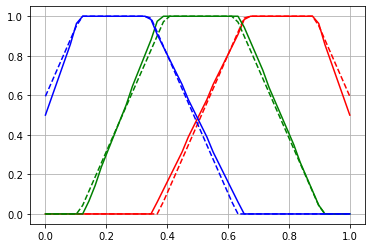

In [1853]:
v = np.linspace(0,1)

r, g, b = cm.jet(v).T[:3]

plt.plot(v,r,'r')
r2 = -3.5*abs(v - 0.77) + 1.4
r2 = np.min([r2, np.ones_like(r2)], axis=0)
r2 = np.max([r2, np.zeros_like(r2)], axis=0)
plt.plot(v, r2, '--r')

plt.plot(v,g,'g')
g2 = -3.5*abs(v - 0.51) + 1.4
g2 = np.min([g2, np.ones_like(g2)], axis=0)
g2 = np.max([g2, np.zeros_like(g2)], axis=0)
plt.plot(v, g2, '--g')

plt.plot(v,b,'b')
b2 = -3.5*abs(v - 0.23) + 1.4
b2 = np.min([b2, np.ones_like(g2)], axis=0)
b2 = np.max([b2, np.zeros_like(g2)], axis=0)
plt.plot(v, b2, '--b')

plt.grid('on')

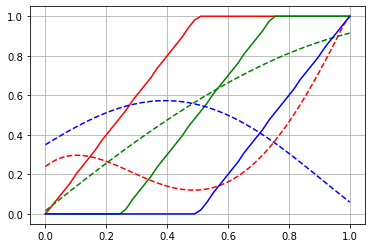

In [1965]:
v = np.linspace(0,1)

r, g, b = cm.afmhot(v).T[:3]

plt.plot(v,r,'r')
r2 = -4.27*v**4 +11.34*v**3 -7.5*v**2 + 1.21*v +  0.24
r2 = np.min([r2, np.ones_like(r2)], axis=0)
r2 = np.max([r2, np.zeros_like(r2)], axis=0)
plt.plot(v, r2, '--r')

plt.plot(v,g,'g')
g2 = -0.176*v**3 -0.17*v**2 + 1.245*v + 0.0156
g2 = np.min([g2, np.ones_like(g2)], axis=0)
g2 = np.max([g2, np.zeros_like(g2)], axis=0)
plt.plot(v, g2, '--g')

plt.plot(v,b,'b')
b2 = 1.31*v**4 -2.29*v**3 -0.25*v**2 + 0.94*v + 0.35
b2 = np.min([b2, np.ones_like(g2)], axis=0)
b2 = np.max([b2, np.zeros_like(g2)], axis=0)
plt.plot(v, b2, '--b')

plt.grid('on')